### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


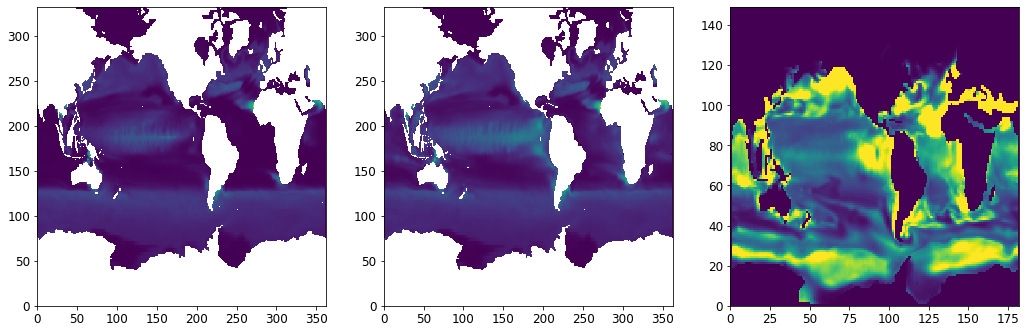

In [4]:
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_1AA7/'
ttom = xr.open_dataset(f'{tdir}ORCA2_1m_19900101_19901231_diad_T.nc')

tukesm = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/oneyear2009ukesm/medusa_bc370o_1m_20090301-20090401_diad-T.nc')
tukesm['PR'] = tukesm['PRD']+tukesm['PRN']
#tukesm = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_diadT_aux/medusa_bc370o_1m_20090401-20090501_diad-T.nc')
tukesm['ML_PR'] = tukesm['ML_PRD']+tukesm['ML_PRN']

fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(16*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

sid = 24*60*60
tvmax = 5e-4*sid

axs[0].pcolormesh(tukesm['ML_PR'][0,:,:], vmin = 0, vmax = tvmax)
axs[1].pcolormesh(tukesm['PR'][0,:,:], vmin = 0, vmax = tvmax)
axs[2].pcolormesh(ttom['PPINT'][2,:,:]*sid*1e3, vmin = 0, vmax = tvmax)

In [5]:

mm_tom = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
mm_tom['area'] = mm_tom.tmask[0,0,:,:] * mm_tom.e1t[0,:,:] * mm_tom.e2t[0,:,:]

ex = False
if ex:
    scens = ['1A','1B','2A','2B','3A','3B']

    yr = 1940; yre = 2099

    for s in range(0,6):
        print(scens[s])
        times = pd.date_range(f"{yr}/01/01",f"{yre+1}/01/01",freq='MS',closed='left')
        #print(len(times))
        savenam = f'./extracted-summary/PPINT_tom_{scens[s]}A7-40s.nc'
        ind = 0
        vals = np.zeros(len(times))
        for y in range(yr,yr+3):#yre+1):
            if (y%30 == 0):
                print(y)
            tdir = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_{scens[s]}A7/'
            w = xr.open_dataset(f'{tdir}ORCA2_1m_{y}0101_{y}1231_diad_T.nc')
            tmld = w.PPINT.sel(y=slice(0,37)).weighted(mm_tom['area'].sel(y=slice(0,37))).mean(dim = ['x','y'])
            vals[ind:ind+12] = tmld.values
            print(vals[ind:ind+12])
            ind = ind+12


        data_vars = {'PPINT':(['time_counter'], vals,
        {'units': 'mol/m2/s',
        'long_name':'mol/m2/s'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/prim-prod.ipynb',
        'desc': ''
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
#         ds.to_netcdf(savenam)
#         plt.plot(ds.time_counter, ds.PPINT)

In [6]:

plt.rc('font', **font)

mod = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'runid':'TOM12_TJ_1AA1'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'runid':'TOM12_TJ_1BA1'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'runid':'TOM12_TJ_2AA1'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'runid':'TOM12_TJ_2BA1'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'runid':'TOM12_TJ_3AA1'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'runid':'TOM12_TJ_3BA1'},
    'PI': {
        'hist_str': '',
        'fut_str': '',
        'name': 'PI OZONE \n PI TEMP.',
        'name2':'PI: OzonePI-PI',
        'color':'silver',
        'runid':'TOM12_TJ_PIA1'}
}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

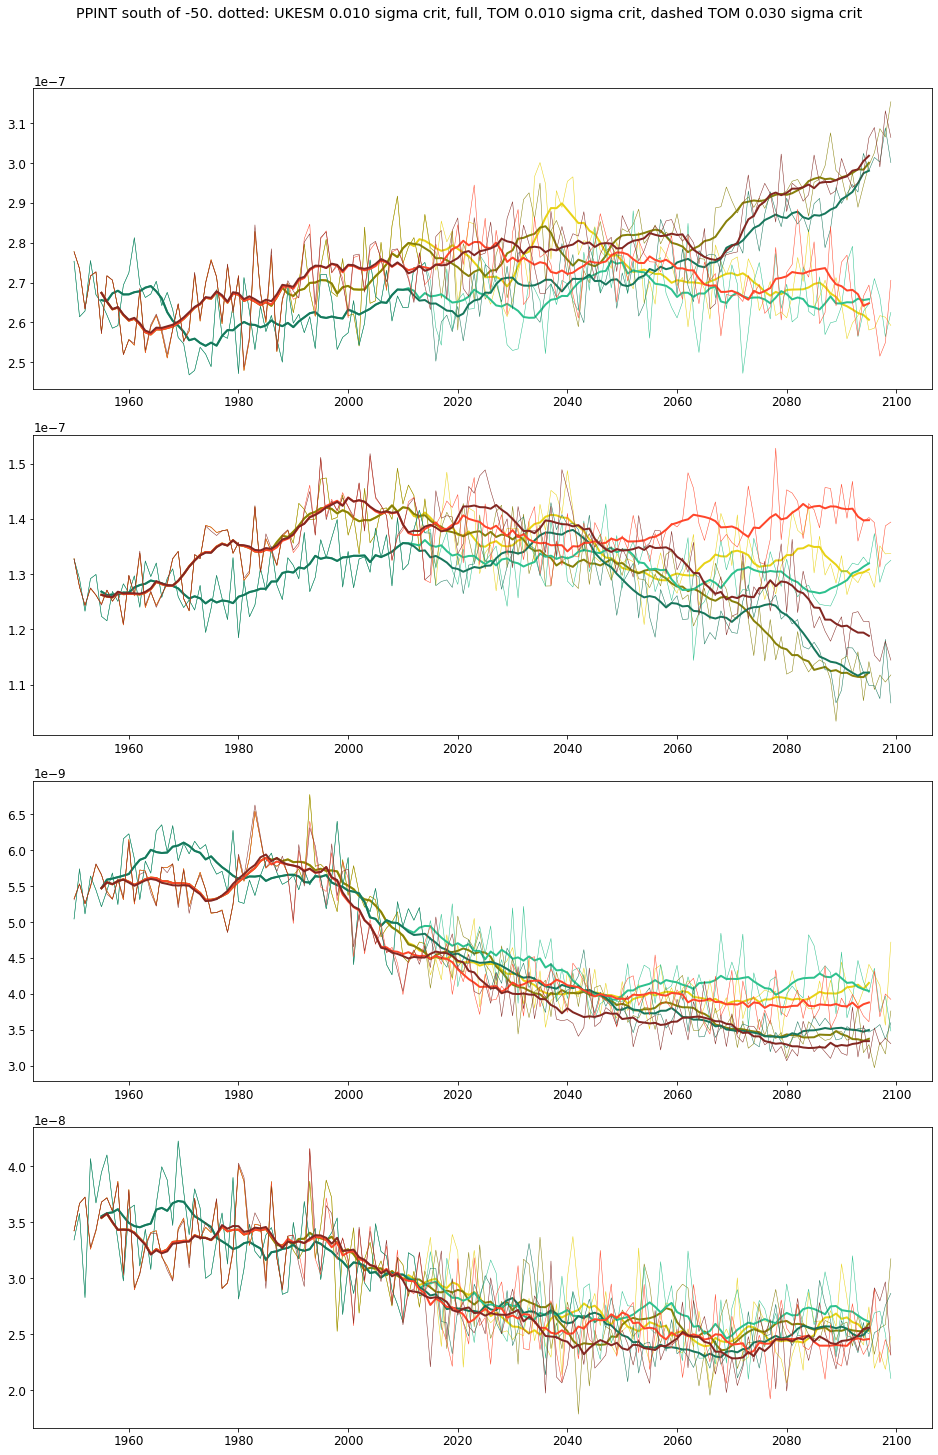

In [7]:
plt.figure()

models = ['1A','1B','2A','2B','3A','3B',\
         ]

seas = ['DJF','MAM','JJA','SON']
    
fact = 1.1
fig, axs = plt.subplots(4,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for m in range(0,6):#len(models)):
         
        
    tmod = xr.open_dataset(f'./extracted-summary/PPINT_tom_{models[m]}A7-40s.nc')
    tmod = tmod.sel(time_counter=slice(f'1950-01-01', f'2100-01-01'))
    for i in range(0,4):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.PPINT, color = mod[models[m]]['color'], \
                        linestyle = '-', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.PPINT, color = mod[models[m]]['color'],\
                        linestyle = '-', linewidth = 2)


plt.suptitle('PPINT south of -50. dotted: UKESM 0.010 sigma crit, full, TOM 0.010 sigma crit, dashed TOM 0.030 sigma crit', y = 1.02)
plt.tight_layout()

In [8]:
extract = False
if extract:
    scendict = {
        # Baynes Sound
        '1A': {
            'hist_str': 'bc370',
            'fut_str': 'be682',
            'name': 'HIST.OZONE \n LOW TEMP.',
            'name2':'1A: NatlOzone-SSP126',
            'color':'#E8D215',
            'color2':'orange'},
        '1B': {
            'hist_str': 'bc370',
            'fut_str': 'ce417',
            'name': 'HIST. OZONE \n HIGH TEMP.',
            'name2':'1B: NatlOzone-SSP370',
            'color':'#87800A',
            'color2':'orangered'},
        '2A': {
            'hist_str': 'cj198',
            'fut_str': 'cj880',
            'name': 'FIXED OZONE \n LOW TEMP.',
            'name2':'2A: Ozone1950-SSP126',
            'color':'#2DC18E',
            'color2':'mediumseagreen'},
        '2B': {
            'hist_str': 'cj198',
            'fut_str': 'cj881',
            'name': 'FIXED OZONE \n HIGH TEMP.',
            'name2':'2B: Ozone1950-SSP370',
            'color':'#18765C',
            'color2':'green'},
        '3A': {
            'hist_str': 'cj200',
            'fut_str': 'cj484',
            'name': '1990 OZONE \n LOW TEMP.',
            'name2':'3A: Ozone1990-SSP126',
            'color':'#FF462B',
            'color2':'dodgerblue'},
        '3B': {
            'hist_str': 'cj200',
            'fut_str': 'cj504',
            'name': '1990 OZONE \n HIGH TEMP.',
            'name2':'3B: Ozone1990-SSP370',
            'color':'#822722',
            'color2':'mediumblue'}
    }

    def make_yearlist_ukesm(yrst, yren, tscen, dtype = 'grid-T'):
        print(f'SCENARIO {tscen}')
        dslist = []

        for y in range(yrst,yren):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/*{tstr}*{y}*{dtype}*')
                dslist.append(td[0])
            except:
                pass
                print(f'FAIL {tscen},{tstr}, {y}')
        return dslist


    ### 
    ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
    ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]
    #print('lol yes the area is correct now')

    ukesm1A = (make_yearlist_ukesm(1950,2100,'1A', dtype = 'aux'))
    ukesm1B = (make_yearlist_ukesm(1950,2100,'1B', dtype = 'aux'))
    ukesm2A = (make_yearlist_ukesm(1950,2100,'2A', dtype = 'aux'))
    ukesm2B = (make_yearlist_ukesm(1950,2100,'2B', dtype = 'aux'))
    ukesm3A = (make_yearlist_ukesm(1950,2100,'3A', dtype = 'aux'))
    ukesm3B = (make_yearlist_ukesm(1950,2100,'3B', dtype = 'aux'))

    
    
    
#     def get_yearly_ppt(ukesmlist, savenam):
#         print(savenam)
#         time1 = time.time()
#         print(len(ukesmlist))
#         cflx_array = np.zeros(len(ukesmlist))
#         year = np.zeros(len(ukesmlist))
#         for i in range(0,len(ukesmlist)):
#             if i%10 == 0:
#                 print(i)
#             test = xr.open_dataset(ukesmlist[i])
#             tmld = w.sel(y=slice(0,114)).weighted(mm_med['area'].sel(y=slice(0,114))).mean(dim = ['x','y'])
#             vals[ind:ind+12] = tmld.ML_PRN.values + tmld.ML_PRD.values
#             ind = ind+12
            
# #             byarea = test.CO2FLUX*ukmesh.area
# #             timed = byarea.sum(dim = ['y', 'x']) #
# #             timed_mmol_day = timed.groupby('time_counter.year').mean() * 1e-18 * 365 * 12 #mmol/day to pG/year
# #             year[i] = (timed_mmol_day.year.values)
# #             print(year[i])
# #             cflx_array[i] = (timed_mmol_day.values)


#         data_vars = {'Cflx':(['year'], cflx_array,
#         {'units': 'Pg/yr',
#         'long_name':'Cflx'}),
#         }
#         # define coordinates
#         coords = {'year': (['year'], year),
#                 }
#         # define global attributes
#         attrs = {'made in':'SOZONE/windAnalyis/oceanFields/prim-prod.ipynb',
#         'desc': 'yearly medusa files, saving only variables of interest'
#         }
#         ds = xr.Dataset(data_vars=data_vars,
#         coords=coords,
#         attrs=attrs)
#         ds.to_netcdf(savenam)

#         time2 = time.time()
#         print(time2-time1)

#     get_yearly_co2(ukesm1A, './extracted-summary/Cflx_ukesm1A.nc')
#     get_yearly_co2(ukesm1B, './extracted-summary/Cflx_ukesm1B.nc')
#     get_yearly_co2(ukesm2A, './extracted-summary/Cflx_ukesm2A.nc')
#     get_yearly_co2(ukesm2B, './extracted-summary/Cflx_ukesm2B.nc')
#     get_yearly_co2(ukesm3A, './extracted-summary/Cflx_ukesm3A.nc')
#     get_yearly_co2(ukesm3B, './extracted-summary/Cflx_ukesm3B.nc')

In [9]:

mm_med = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
mm_med['area'] = mm_med.tmask[0,:,:] * mm_med.e1t[:,:] * mm_med.e2t[:,:]


ex = False
if ex:
    scens = ['1A','1B','2A','2B','3A','3B']

    yr = 1950; yre = 2099

    for s in scens:
        
        print(s)
        ukesmlist = (make_yearlist_ukesm(1950,2100,s, dtype = 'aux'))
        
        times = pd.date_range(f"{yr}/01/01",f"{yre+1}/01/01",freq='MS',closed='left')
        print(len(times))
        savenam = f'./extracted-summary/ML_PP_ukesm_{s}.nc'
        ind = 0
        vals = np.zeros(len(times))
        for y in range(yr,yre+1):

            if (y%30 == 0):
                print(y)
            
#             tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/'
#             w = xr.open_dataset(f'{tdir}/nemo_scen_{s}_1m_{y}_fy_grid-T.nc')
            
            test = xr.open_dataset(ukesmlist[y-1950])
            tmld = w.sel(y=slice(0,114)).weighted(mm_med['area'].sel(y=slice(0,114))).mean(dim = ['x','y'])
            vals[ind:ind+12] = tmld.ML_PRN.values + tmld.ML_PRD.values
            ind = ind+12

        data_vars = {'ML_PP':(['time_counter'], vals,
        {'units': 'm',
        'long_name':'prim prod in mixed layer'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/prim-prod.ipynb',
        'desc': ''
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)
#         plt.plot(ds.time_counter, ds.somxl010)

<Figure size 432x288 with 0 Axes>

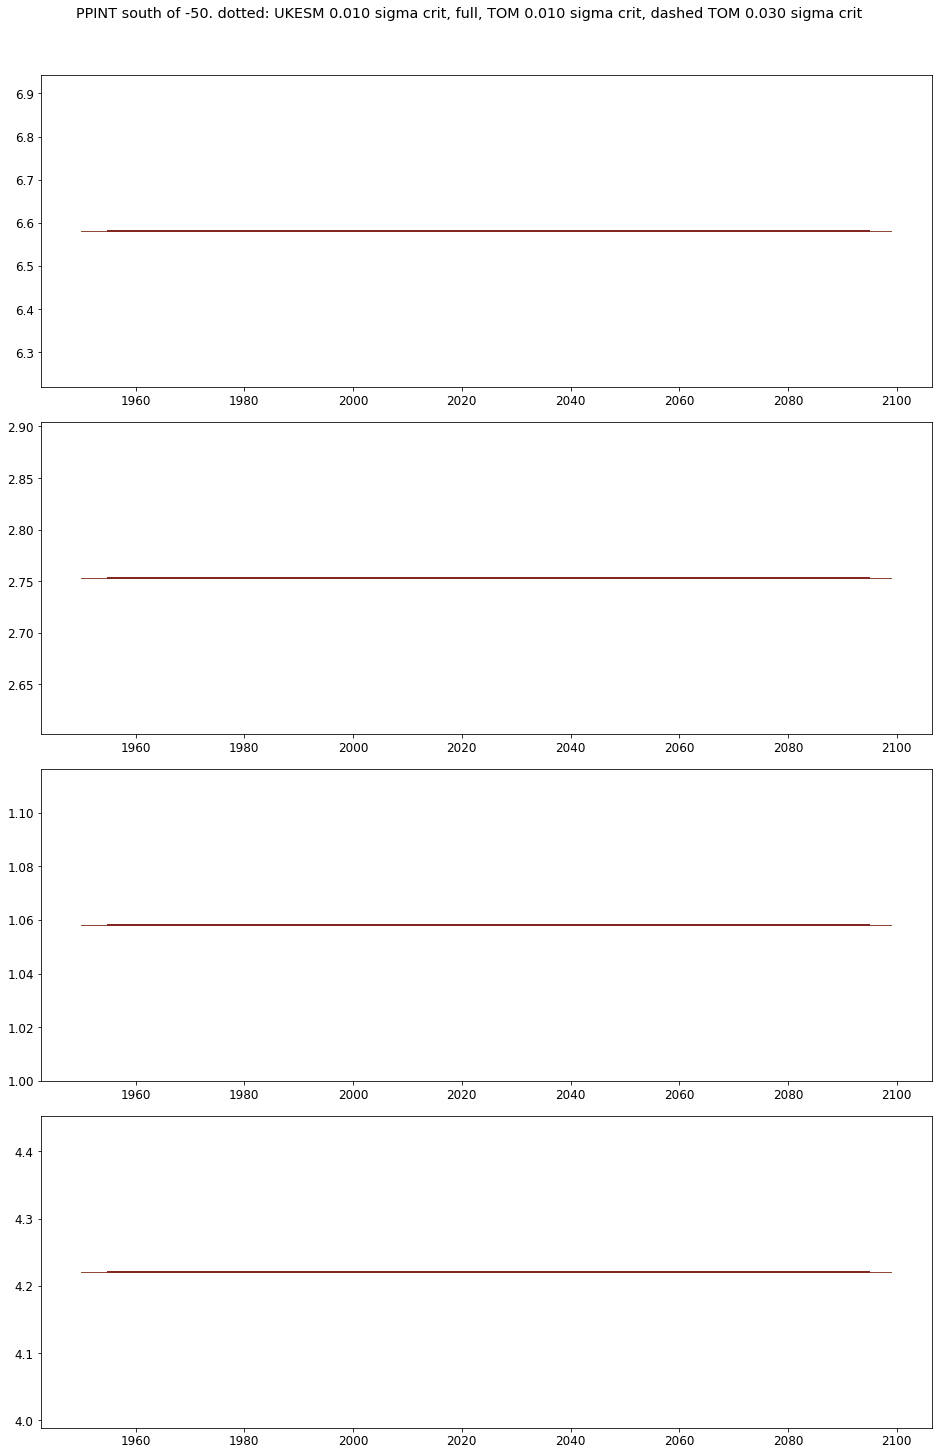

In [10]:
plt.figure()

models = ['1A','1B','2A','2B','3A','3B',\
         ]

seas = ['DJF','MAM','JJA','SON']
    
fact = 1.1
fig, axs = plt.subplots(4,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for m in range(0,6):#len(models)):
         
        
    tmod = xr.open_dataset(f'./extracted-summary/ML_PP_ukesm_{models[m]}.nc')
    tmod = tmod.sel(time_counter=slice(f'1950-01-01', f'2100-01-01'))
    for i in range(0,4):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.ML_PP, color = mod[models[m]]['color'], \
                        linestyle = '-', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.ML_PP, color = mod[models[m]]['color'],\
                        linestyle = '-', linewidth = 2)


plt.suptitle('PPINT south of -50. dotted: UKESM 0.010 sigma crit, full, TOM 0.010 sigma crit, dashed TOM 0.030 sigma crit', y = 1.02)
plt.tight_layout()

## PR ppt medusa


In [11]:
ex = False

mm_med = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
mm_med['area'] = mm_med.tmask[0,:,:] * mm_med.e1t[:,:] * mm_med.e2t[:,:]


scendict = {
    # Baynes Sound
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

def make_yearlist_ukesm(yrst, yren, tscen, dtype = 'grid-T'):
    print(f'SCENARIO {tscen}')
    dslist = []

    for y in range(yrst,yren):
        if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
            tstr = scendict['1A']['hist_str']
        elif y<2015:
            tstr = scendict[tscen]['hist_str']

        else:
            tstr = scendict[tscen]['fut_str']

        try:
            td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/*{tstr}*{y}*{dtype}*')
            dslist.append(td[0])
        except:
            pass
            print(f'FAIL {tscen},{tstr}, {y}')
    return dslist

if ex:
    scens = ['1A','1B','2A','2B','3A','3B']

    yr = 1950; yre = 2099

    for s in scens:
        
        print(s)
        ukesmlist = (make_yearlist_ukesm(1950,2100,s, dtype = 'PR'))
        
        times = pd.date_range(f"{yr}/01/01",f"{yre+1}/01/01",freq='MS',closed='left')
        print(len(times))
        savenam = f'./extracted-summary/PP_ukesm_{s}.nc'
        ind = 0
        vals = np.zeros(len(times))
        for y in range(yr,yre+1):

            if (y%30 == 0):
                print(y)
            
#             tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/'
#             w = xr.open_dataset(f'{tdir}/nemo_scen_{s}_1m_{y}_fy_grid-T.nc')
            
            test = xr.open_dataset(ukesmlist[y-1950])
            tmld = test.sel(y=slice(0,114)).weighted(mm_med['area'].sel(y=slice(0,114))).mean(dim = ['x','y'])
            vals[ind:ind+12] = tmld.PRN.values + tmld.PRD.values
            ind = ind+12

        data_vars = {'PP':(['time_counter'], vals,
        {'units': '',
        'long_name':'prim prod depth integrated'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/prim-prod.ipynb',
        'desc': ''
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)
#         plt.plot(ds.time_counter, ds.somxl010)

<Figure size 432x288 with 0 Axes>

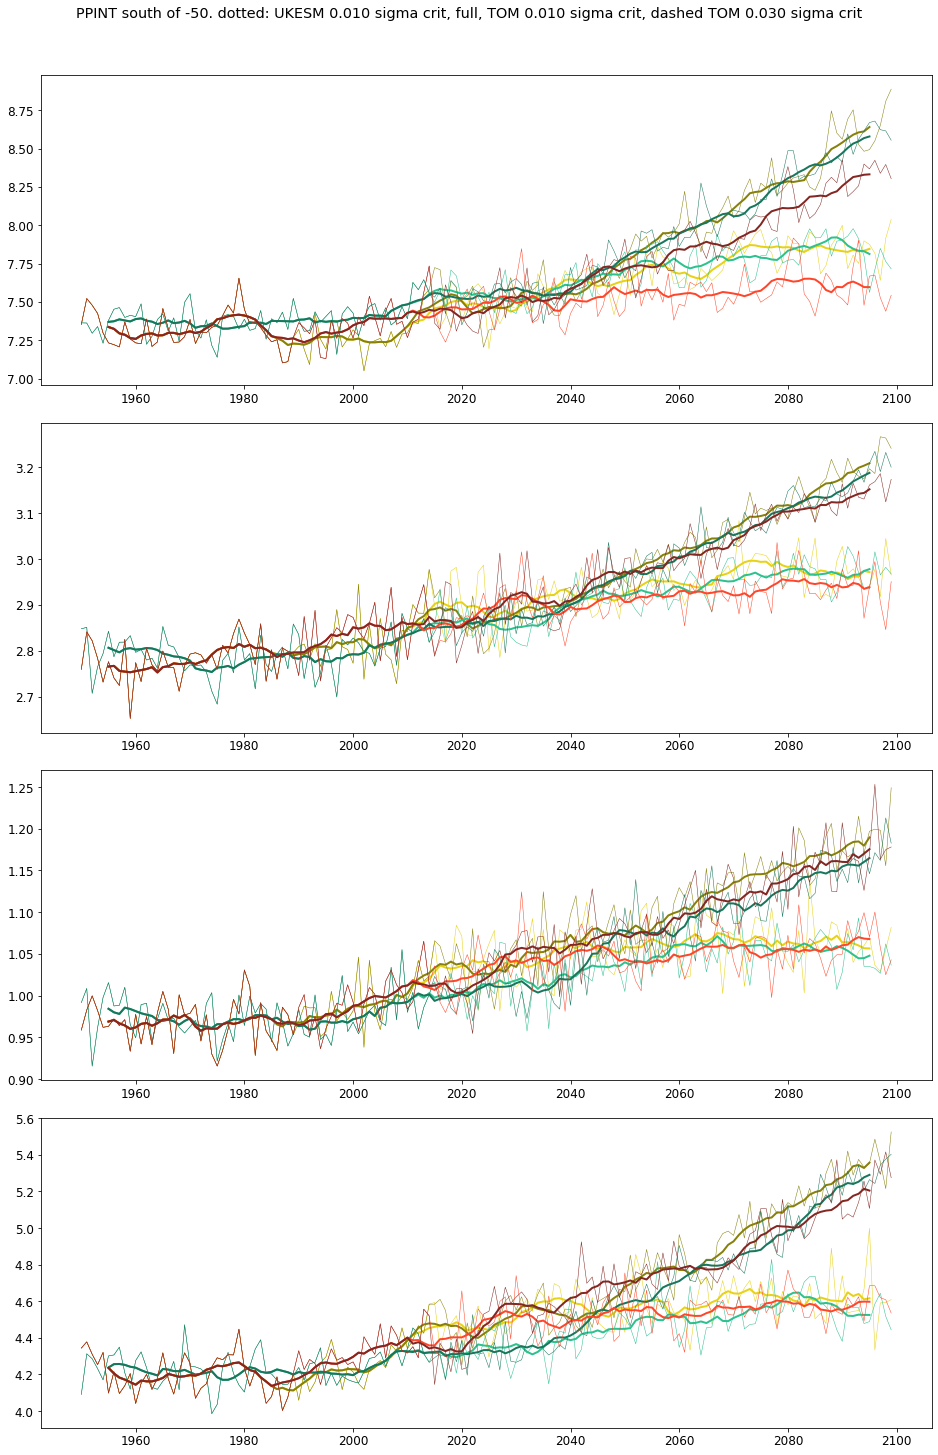

In [12]:
plt.figure()

models = ['1A','1B','2A','2B','3A','3B',\
         ]

seas = ['DJF','MAM','JJA','SON']
    
fact = 1.1
fig, axs = plt.subplots(4,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for m in range(0,6):#len(models)):
         
        
    tmod = xr.open_dataset(f'./extracted-summary/PP_ukesm_{models[m]}.nc')
    tmod = tmod.sel(time_counter=slice(f'1950-01-01', f'2100-01-01'))
    for i in range(0,4):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.PP, color = mod[models[m]]['color'], \
                        linestyle = '-', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.PP, color = mod[models[m]]['color'],\
                        linestyle = '-', linewidth = 2)


plt.suptitle('PPINT south of -50. dotted: UKESM 0.010 sigma crit, full, TOM 0.010 sigma crit, dashed TOM 0.030 sigma crit', y = 1.02)
plt.tight_layout()

In [13]:
#mmol-N/m2/d
#mol N/m2/s

<Figure size 432x288 with 0 Axes>

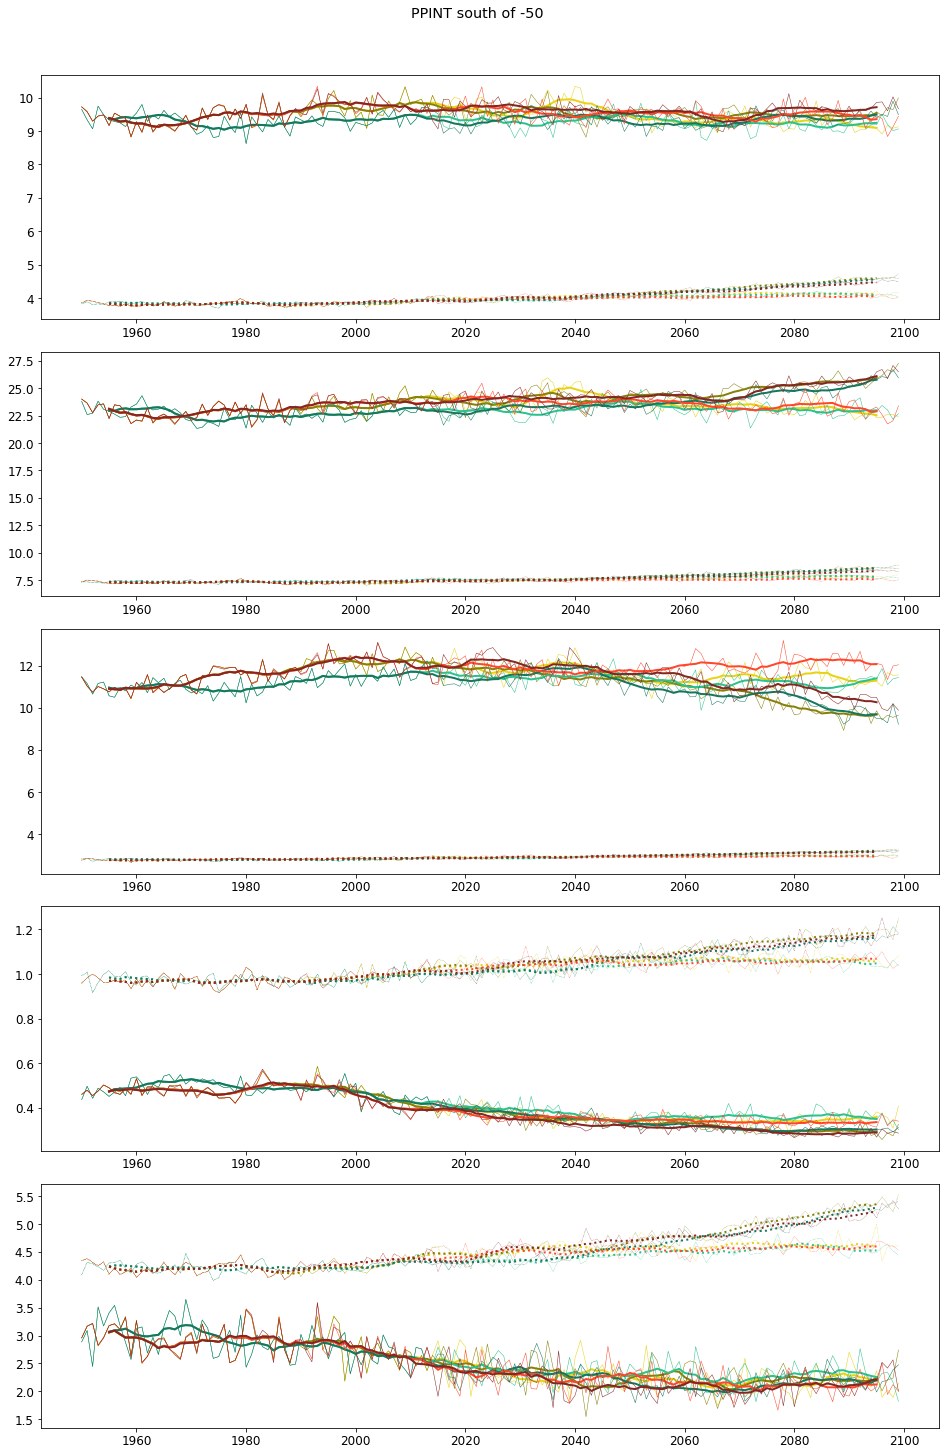

In [14]:
plt.figure()

models = ['1A','1B','2A','2B','3A','3B',\
         ]

seas = ['DJF','MAM','JJA','SON']
    
fact = 1.1
fig, axs = plt.subplots(5,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
sid = 24*3600

for m in range(0,6):#len(models)):
         
        
    tmod = xr.open_dataset(f'./extracted-summary/PPINT_tom_{models[m]}A7-40s.nc')
    tmod = tmod.sel(time_counter=slice(f'1950-01-01', f'2100-01-01'))
    tpl = tmod
    tv = tpl.groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    axs[0].plot(tv.year,tv.PPINT*sid*1000, color = mod[models[m]]['color'], \
                linestyle = '-', linewidth = 0.5)            
    axs[0].plot(tv_rol.year,tv_rol.PPINT*sid*1000, color = mod[models[m]]['color'],\
                linestyle = '-', linewidth = 2)
    for i in range(1,5):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i-1]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.PPINT*sid*1000, color = mod[models[m]]['color'], \
                        linestyle = '-', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.PPINT*sid*1000, color = mod[models[m]]['color'],\
                        linestyle = '-', linewidth = 2)

for m in range(0,6):#len(models)):
         
        
    tmod = xr.open_dataset(f'./extracted-summary/PP_ukesm_{models[m]}.nc')
    tmod = tmod.sel(time_counter=slice(f'1950-01-01', f'2100-01-01'))
    tpl = tmod
    tv = tpl.groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    axs[0].plot(tv.year,tv.PP, color = mod[models[m]]['color'], \
                linestyle = ':', linewidth = 0.5)            
    axs[0].plot(tv_rol.year,tv_rol.PP, color = mod[models[m]]['color'],\
                linestyle = ':', linewidth = 2)

    for i in range(1,5):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i-1]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.PP, color = mod[models[m]]['color'], \
                        linestyle = ':', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.PP, color = mod[models[m]]['color'],\
                        linestyle = ':', linewidth = 2)

            

plt.suptitle('PPINT south of -50', y = 1.02)
plt.tight_layout()

In [15]:
PP_ukesm_1A = xr.open_dataset(f'./extracted-summary/PP_ukesm_1A.nc')
PP_ukesm_1B = xr.open_dataset(f'./extracted-summary/PP_ukesm_1B.nc')
PP_ukesm_2A = xr.open_dataset(f'./extracted-summary/PP_ukesm_2A.nc')
PP_ukesm_2B = xr.open_dataset(f'./extracted-summary/PP_ukesm_2B.nc')
PP_ukesm_3A = xr.open_dataset(f'./extracted-summary/PP_ukesm_3A.nc')
PP_ukesm_3B = xr.open_dataset(f'./extracted-summary/PP_ukesm_3B.nc')

PP_tom_1A = xr.open_dataset(f'./extracted-summary/PPINT_tom_1AA7-40s.nc')
PP_tom_1B = xr.open_dataset(f'./extracted-summary/PPINT_tom_1BA7-40s.nc')
PP_tom_2A = xr.open_dataset(f'./extracted-summary//PPINT_tom_2AA7-40s.nc')
PP_tom_2B = xr.open_dataset(f'./extracted-summary//PPINT_tom_2BA7-40s.nc')
PP_tom_3A = xr.open_dataset(f'./extracted-summary//PPINT_tom_3AA7-40s.nc')
PP_tom_3B = xr.open_dataset(f'./extracted-summary/PPINT_tom_3BA7-40s.nc')

In [16]:
PP_tom_1A['PP'] = PP_tom_1A.PPINT *sid*1000
PP_tom_1B['PP'] = PP_tom_1B.PPINT *sid*1000
PP_tom_2A['PP'] = PP_tom_2A.PPINT *sid*1000
PP_tom_2B['PP'] = PP_tom_2B.PPINT *sid*1000
PP_tom_3A['PP'] = PP_tom_3A.PPINT *sid*1000
PP_tom_3B['PP'] = PP_tom_3B.PPINT *sid*1000

In [17]:
def get_effect_ozone(sc1,sc2,dec1=1950, dec2=2090,var = 'PP', seas = 'FY'):

    ##for warming just have 
    sc = sc1 - sc2
    
    if seas == 'FY':
        
        start = sc[var].sel(time_counter=slice(f'{dec1}-01-01', f'{dec1+10}-01-01')).\
        groupby('time_counter.year').mean().mean().values
        end = sc[var].sel(time_counter=slice(f'{dec2}-01-01', f'{dec2+10}-01-01')).\
        groupby('time_counter.year').mean().mean().values
        
    else:
        
        start = sc[var].sel(time_counter=slice(f'{dec1}-01-01', f'{dec1+10}-01-01'))
        start = start.sel(time_counter=(start['time_counter.season'] == seas)).\
        groupby('time_counter.year').mean().mean().values
        
        end = sc[var].sel(time_counter=slice(f'{dec2}-01-01', f'{dec2+10}-01-01'))
        end = end.sel(time_counter=(end['time_counter.season'] == seas)).\
        groupby('time_counter.year').mean().mean().values
    
    effect1 = end-start # the better one i think 
    effect2 = end
    
    return effect1, effect2

def get_effect_warming(sc1,dec1=1950, dec2=2090,var = 'PP', seas = 'FY'):

    ##for warming just have 
    sc = sc1
    
    if seas == 'FY':
        
        start = sc[var].sel(time_counter=slice(f'{dec1}-01-01', f'{dec1+10}-01-01')).\
        groupby('time_counter.year').mean().mean().values
        end = sc[var].sel(time_counter=slice(f'{dec2}-01-01', f'{dec2+10}-01-01')).\
        groupby('time_counter.year').mean().mean().values

    else:
        
        start = sc[var].sel(time_counter=slice(f'{dec1}-01-01', f'{dec1+10}-01-01'))
        start = start.sel(time_counter=(start['time_counter.season'] == seas)).\
        groupby('time_counter.year').mean().mean().values
        
        end = sc[var].sel(time_counter=slice(f'{dec2}-01-01', f'{dec2+10}-01-01'))
        end = end.sel(time_counter=(end['time_counter.season'] == seas)).\
        groupby('time_counter.year').mean().mean().values
    
    effect1 = end-start # the better one i think 
    effect2 = end
    
    return effect1, effect2

Text(0.5, 1.02, 'effects of warming and ozone evolution on PP, {2090-2100} relative to {1950-1960}')

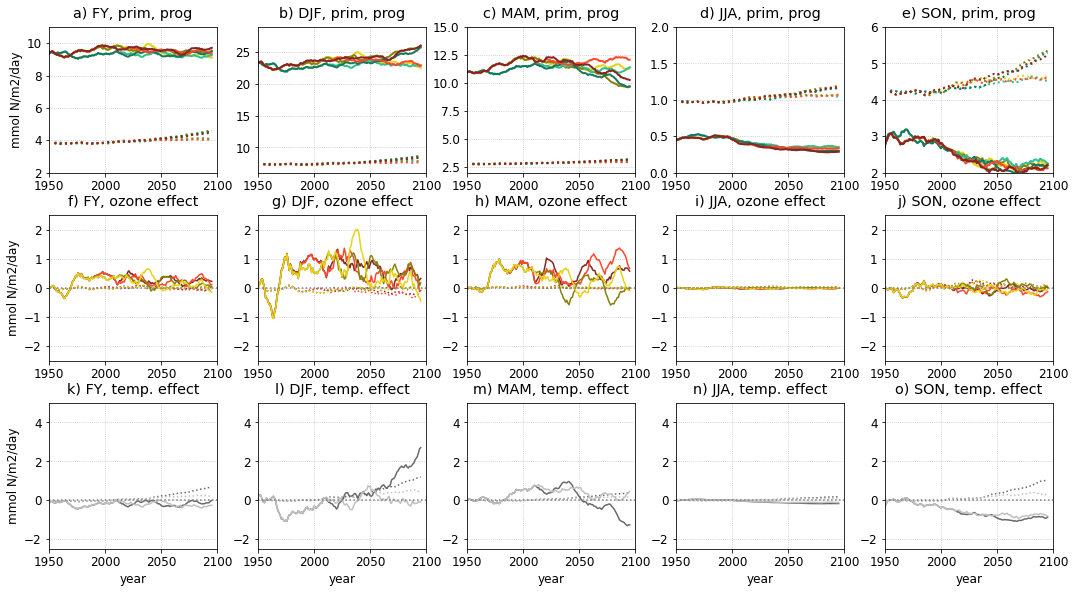

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


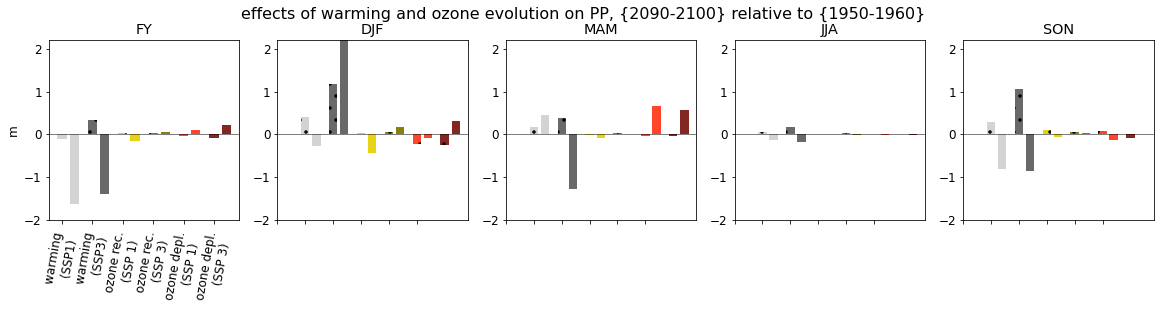

In [18]:
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

tlw = 1.5
tlw2 = 0.3 #linewidth
fact = 1.2
ypos = 1.02
fs2 = 10
var = 'PP'; vardesc = 'prim, prog'; ylab = 'mmol N/m2/day'

fig, axs = plt.subplots(3,5, figsize=(15*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


# #####
wspdset = [PP_ukesm_1A, PP_ukesm_1B, PP_ukesm_2A, PP_ukesm_2B, PP_ukesm_3A, PP_ukesm_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

PP_ukesm_2A_50 = PP_ukesm_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
PP_ukesm_2B_50 = PP_ukesm_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(PP_ukesm_3B-PP_ukesm_2B), (PP_ukesm_3A-PP_ukesm_2A), \
              (PP_ukesm_1B-PP_ukesm_2B), (PP_ukesm_1A-PP_ukesm_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']

#wspdset_t = [(wspd_2B-wspd_2B_50), (wspd_2A-wspd_2A_50)]
cols_t = ['dimgrey', 'silver']
scens_t = ['high temp.','low temp.']

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1)
    
#axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)

##### ozone effect
ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1)
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1)
    
#### temperature effect
ind = 10
tv = PP_ukesm_2B[var].groupby('time_counter.year').mean()-\
PP_ukesm_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = PP_ukesm_2B[var].sel(time_counter=(PP_ukesm_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
PP_ukesm_2B_50[var].sel(time_counter=(PP_ukesm_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = PP_ukesm_2B[var].sel(time_counter=(PP_ukesm_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
PP_ukesm_2B_50[var].sel(time_counter=(PP_ukesm_2B_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])
    
tv = PP_ukesm_2B[var].sel(time_counter=(PP_ukesm_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
PP_ukesm_2B_50[var].sel(time_counter=(PP_ukesm_2B_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = PP_ukesm_2B[var].sel(time_counter=(PP_ukesm_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
PP_ukesm_2B_50[var].sel(time_counter=(PP_ukesm_2B_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])    
    
tv = PP_ukesm_2A[var].groupby('time_counter.year').mean()-\
PP_ukesm_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = PP_ukesm_2A[var].sel(time_counter=(PP_ukesm_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
PP_ukesm_2A_50[var].sel(time_counter=(PP_ukesm_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = PP_ukesm_2A[var].sel(time_counter=(PP_ukesm_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
PP_ukesm_2A_50[var].sel(time_counter=(PP_ukesm_2A_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])
    
tv = PP_ukesm_2A[var].sel(time_counter=(PP_ukesm_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
PP_ukesm_2A_50[var].sel(time_counter=(PP_ukesm_2A_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = PP_ukesm_2A[var].sel(time_counter=(PP_ukesm_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
PP_ukesm_2A_50[var].sel(time_counter=(PP_ukesm_2A_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])  
##low T

# #####
wspdset = [PP_tom_1A, PP_tom_1B, PP_tom_2A, PP_tom_2B, PP_tom_3A, PP_tom_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

PP_tom_2A_50 = PP_tom_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
PP_tom_2B_50 = PP_tom_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(PP_tom_3B-PP_tom_2B), (PP_tom_3A-PP_tom_2A), \
              (PP_tom_1B-PP_tom_2B), (PP_tom_1A-PP_tom_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']

#wspdset_t = [(wspd_2B-wspd_2B_50), (wspd_2A-wspd_2A_50)]
cols_t = ['dimgrey', 'silver']
scens_t = ['high temp.','low temp.']

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1)
    
#axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)

##### ozone effect
ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1)
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1)
    
#### temperature effect
ind = 10
tv = PP_tom_2B[var].groupby('time_counter.year').mean()-\
PP_tom_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = PP_tom_2B[var].sel(time_counter=(PP_tom_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
PP_tom_2B_50[var].sel(time_counter=(PP_tom_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = PP_tom_2B[var].sel(time_counter=(PP_tom_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
PP_tom_2B_50[var].sel(time_counter=(PP_tom_2B_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])
    
tv = PP_tom_2B[var].sel(time_counter=(PP_tom_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
PP_tom_2B_50[var].sel(time_counter=(PP_tom_2B_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = PP_tom_2B[var].sel(time_counter=(PP_tom_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
PP_tom_2B_50[var].sel(time_counter=(PP_tom_2B_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])    
    
tv = PP_tom_2A[var].groupby('time_counter.year').mean()-\
PP_tom_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = PP_tom_2A[var].sel(time_counter=(PP_tom_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
PP_tom_2A_50[var].sel(time_counter=(PP_tom_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = PP_tom_2A[var].sel(time_counter=(PP_tom_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
PP_tom_2A_50[var].sel(time_counter=(PP_tom_2A_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])
    
tv = PP_tom_2A[var].sel(time_counter=(PP_tom_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
PP_tom_2A_50[var].sel(time_counter=(PP_tom_2A_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = PP_tom_2A[var].sel(time_counter=(PP_tom_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
PP_tom_2A_50[var].sel(time_counter=(PP_tom_2A_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])  
##low T

for i in range(0,15):
    axs[i].grid(color = 'grey', linestyle = ':', alpha = 0.5)
    
### effect
ymi = [2,6,2,0,2]
yma = [11,29,15,2,6]
tits0 = [f'a) FY, {vardesc}',f'b) DJF, {vardesc}',f'c) MAM, {vardesc}',\
        f'd) JJA, {vardesc}',f'e) SON, {vardesc}']
for i in range(0,5):
    axs[i].set_title(tits0[i], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[2].legend(loc = 'upper left', ncol = 2, fontsize = fs2)
    #axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)
    #axs[3].legend(bbox_to_anchor = (1,1), ncol = 2, fontsize = 10)
    axs[i].set_ylim([ymi[i], yma[i]])
    axs[i].set_xlabel('')
    
tits = ['f) FY, ozone effect', 'g) DJF, ozone effect','h) MAM, ozone effect',\
        'i) JJA, ozone effect','j) SON, ozone effect']
ind = 5; ymi = -2.5; yma = 2.5
for i in range(0+ind,5+ind):
    axs[i].set_title(tits[i-ind], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[2+ind].legend(loc = 'upper right', ncol = 2, fontsize = fs2-2)
    axs[i].set_ylim([ymi,yma])
    axs[i].axhline(y=0, color = 'grey', linestyle = ':')
    axs[i].set_xlabel('')
    
ind = 10; ymi = -2.5; yma = 5
tits1 = ['k) FY, temp. effect', 'l) DJF, temp. effect','m) MAM, temp. effect',\
        'n) JJA, temp. effect','o) SON, temp. effect']
for i in range(0+ind,5+ind):
    
    axs[i].set_title(tits1[i-ind], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[1+ind].legend(loc = 'upper left', fontsize = fs2)
    axs[i].set_ylim([ymi,yma])
    axs[i].axhline(y=0, color = 'grey', linestyle = ':')
    
axs[0].set_ylabel(f'{ylab}')
axs[5].set_ylabel(f'{ylab}')
axs[10].set_ylabel(f'{ylab}')
    
    
    
tsp = 0.24
plt.subplots_adjust(wspace=tsp, hspace=tsp+0.05)    


fact = 1.1; tw = 0.3
fig, axs = plt.subplots(1,5, figsize=(18*fact, 3*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0; tseas = 'FY'
def plot_effects(ind,tseas):
    e_wl, e2 = get_effect_warming(PP_ukesm_2A, seas = tseas, var = 'PP')
    axs[ind].bar(1,e_wl, color = 'lightgrey',width=tw, hatch = '.')
    e_wh, e2 = get_effect_warming(PP_ukesm_2B, seas = tseas, var = 'PP')
    axs[ind].bar(2,e_wh, color = 'dimgrey',width=tw, hatch = '.')
    e, e2 = get_effect_ozone(PP_ukesm_1A, PP_ukesm_2A, seas = tseas, var = 'PP')
    axs[ind].bar(3,e2, color = scendict['1A']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(PP_ukesm_1B, PP_ukesm_2B, seas = tseas, var = 'PP')
    axs[ind].bar(4,e2, color = scendict['1B']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(PP_ukesm_3A, PP_ukesm_2A, seas = tseas, var = 'PP')
    axs[ind].bar(5,e2, color = scendict['3A']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(PP_ukesm_3B, PP_ukesm_2B, seas = tseas, var = 'PP')
    axs[ind].bar(6,e2, color = scendict['3B']['color'],width=tw, hatch = '.')

def plot_effects_tom(ind,tseas):
    e_wl, e2 = get_effect_warming(PP_tom_2A, seas = tseas, var = 'PP')
    axs[ind].bar(1.4,e_wl, color = 'lightgrey',width=tw)
    e_wh, e2 = get_effect_warming(PP_tom_2B, seas = tseas, var = 'PP')
    axs[ind].bar(2.4,e_wh, color = 'dimgrey',width=tw)
    e, e2 = get_effect_ozone(PP_tom_1A, PP_tom_2A, seas = tseas, var = 'PP')
    axs[ind].bar(3.4,e2, color = scendict['1A']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(PP_tom_1B, PP_tom_2B, seas = tseas, var = 'PP')
    axs[ind].bar(4.4,e2, color = scendict['1B']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(PP_tom_3A, PP_tom_2A, seas = tseas, var = 'PP')
    axs[ind].bar(5.4,e2, color = scendict['3A']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(PP_tom_3B, PP_tom_2B, seas = tseas, var = 'PP')
    axs[ind].bar(6.4,e2, color = scendict['3B']['color'],width=tw, hatch = '')

ind = 0; tseas = 'FY'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(1,7,1))
axs[ind].set_xticklabels(['warming \n(SSP1)', 'warming \n (SSP3)', 'ozone rec. \n (SSP 1)',\
                         'ozone rec. \n (SSP 3)','ozone depl. \n (SSP 1)','ozone depl. \n (SSP 3)'], rotation = 80)
ind = 1; tseas = 'DJF'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 2; tseas = 'MAM'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 3; tseas = 'JJA'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 4; tseas = 'SON'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)

tits = ['FY','DJF','MAM','JJA','SON',]
for ind in range(0,5):
    axs[ind].axhline(y=0, color = 'k', linewidth = 0.5)
    axs[ind].set_ylim(-2,2.2)
    axs[ind].set_title(tits[ind])
axs[0].set_ylabel('m')
plt.suptitle('effects of warming and ozone evolution on PP, {2090-2100} relative to {1950-1960}', y = 1.02, fontsize = 16)


## cflx

In [19]:
Cflx_ukesm_1A = xr.open_dataset(f'./extracted-summary/Cflx_ukesm1A.nc')
Cflx_ukesm_1B = xr.open_dataset(f'./extracted-summary/Cflx_ukesm1B.nc')
Cflx_ukesm_2A = xr.open_dataset(f'./extracted-summary/Cflx_ukesm2A.nc')
Cflx_ukesm_2B = xr.open_dataset(f'./extracted-summary/Cflx_ukesm2B.nc')
Cflx_ukesm_3A = xr.open_dataset(f'./extracted-summary/Cflx_ukesm3A.nc')
Cflx_ukesm_3B = xr.open_dataset(f'./extracted-summary/Cflx_ukesm3B.nc')

# Cflx_tom_1A = xr.open_dataset(f'./extracted-summary/Cflx_tom_1AA7.nc')
# Cflx_tom_1B = xr.open_dataset(f'./extracted-summary/Cflx_tom_1BA7.nc')
# Cflx_tom_2A = xr.open_dataset(f'./extracted-summary//Cflx_tom_2AA7.nc')
# Cflx_tom_2B = xr.open_dataset(f'./extracted-summary//Cflx_tom_2BA7.nc')
# Cflx_tom_3A = xr.open_dataset(f'./extracted-summary//Cflx_tom_3AA7.nc')
# Cflx_tom_3B = xr.open_dataset(f'./extracted-summary/Cflx_tom_3BA7.nc')

In [20]:
Cflx_ukesm_1A

<xarray.Dataset>
Dimensions:  (year: 150)
Coordinates:
  * year     (year) float64 1.95e+03 1.951e+03 1.952e+03 ... 2.098e+03 2.099e+03
Data variables:
    Cflx     (year) float64 ...
Attributes:
    made in:  SOZONEwindAnalyis/oceanFields/investigate-Carbon-jump.ipynb
    desc:     yearly medusa files, saving only variables of interest

## carbon flux

In [21]:

extract = False
if extract:

    def make_yearlist_tom(yrst,yren, tstr, dtype = 'diad_T'):
        print(tstr)
        
        dslist = []
        
        for y in range(yrst,yren):

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_{tstr}/*{y}0101*{dtype}*')
                dslist.append(td[0])
            except:
                pass
                print(f'FAIL {tstr}, {y}')
        return dslist



    ### 
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]


    def get_yearly_co2_tom(tomlist, savenam):
        
        print(savenam)
        time1 = time.time()
        print(len(tomlist))
        cflx_array = np.zeros(len(tomlist)*12)
        times = pd.date_range(f"{1950}/01/01",f"{2100}/01/01",freq='MS',closed='left')
        print(len(times))
        year = np.zeros(len(tomlist))
        ind = 0
        for i in range(0,len(tomlist)):
            
            if i%10 == 0:
                print(i)
            test = xr.open_dataset(tomlist[i]) #mol/s

            siy = 60*60*24*365
            byarea = test.Cflx*tmesh.csize#mol/m2/s to mol/s
            timed = byarea.sum(dim = ['y', 'x']) * 1e-15 * siy * 12 #mol/ to pG/year
#             print(timed)
#             #timed_mmol_day = timed.groupby('time_counter.year').mean() * 1e-15 * siy * 12 #mol/ to pG/year
            #year[i] = (timed_mmol_day.year.values)
            cflx_array[ind:ind+12] = (timed)
            ind = ind+12



        data_vars = {'Cflx':(['time_counter'], cflx_array,
        {'units': 'Pg/yr',
        'long_name':'Cflx'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/prim-prod.ipynb',
        'desc': 'yearly meduA7 files, A7ving only variables of interest'
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)

        time2 = time.time()
        print(time2-time1)
    
    
    tom1A = (make_yearlist_tom(1950,2100,'1AA7', ))
    get_yearly_co2_tom(tom1A, './extracted-summary/CflxTS_tom_1AA7.nc')
    
#     tom1B = (make_yearlist_tom(1950,2100,'1BA7', ))
#     tom2A = (make_yearlist_tom(1950,2100,'2AA7', ))
#     tom2B = (make_yearlist_tom(1950,2100,'2BA7', ))
#     tom3A = (make_yearlist_tom(1950,2100,'3AA7', ))
#     tom3B = (make_yearlist_tom(1950,2100,'3BA7', ))
#     get_yearly_co2_tom(tom1B, './extracted-summary/CflxTS_tom_1BA7.nc')
#     get_yearly_co2_tom(tom2A, './extracted-summary/CflxTS_tom_2AA7.nc')
#     get_yearly_co2_tom(tom2B, './extracted-summary/CflxTS_tom_2BA7.nc')
#     get_yearly_co2_tom(tom3A, './extracted-summary/CflxTS_tom_3AA7.nc')
#     get_yearly_co2_tom(tom3B, './extracted-summary/CflxTS_tom_3BA7.nc')

In [22]:
w = xr.open_dataset('./extracted-summary/CflxTS_tom_1AA7.nc')

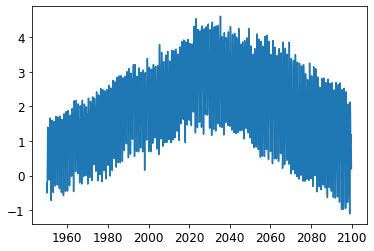

In [23]:
plt.plot(w.time_counter,w.Cflx)

In [24]:
extract = False
if extract:
    scendict = {
        # Baynes Sound
        '1A': {
            'hist_str': 'bc370',
            'fut_str': 'be682',
            'name': 'HIST.OZONE \n LOW TEMP.',
            'name2':'1A: NatlOzone-SSP126',
            'color':'#E8D215',
            'color2':'orange'},
        '1B': {
            'hist_str': 'bc370',
            'fut_str': 'ce417',
            'name': 'HIST. OZONE \n HIGH TEMP.',
            'name2':'1B: NatlOzone-SSP370',
            'color':'#87800A',
            'color2':'orangered'},
        '2A': {
            'hist_str': 'cj198',
            'fut_str': 'cj880',
            'name': 'FIXED OZONE \n LOW TEMP.',
            'name2':'2A: Ozone1950-SSP126',
            'color':'#2DC18E',
            'color2':'mediumseagreen'},
        '2B': {
            'hist_str': 'cj198',
            'fut_str': 'cj881',
            'name': 'FIXED OZONE \n HIGH TEMP.',
            'name2':'2B: Ozone1950-SSP370',
            'color':'#18765C',
            'color2':'green'},
        '3A': {
            'hist_str': 'cj200',
            'fut_str': 'cj484',
            'name': '1990 OZONE \n LOW TEMP.',
            'name2':'3A: Ozone1990-SSP126',
            'color':'#FF462B',
            'color2':'dodgerblue'},
        '3B': {
            'hist_str': 'cj200',
            'fut_str': 'cj504',
            'name': '1990 OZONE \n HIGH TEMP.',
            'name2':'3B: Ozone1990-SSP370',
            'color':'#822722',
            'color2':'mediumblue'}
    }

    def make_yearlist_ukesm(yrst, yren, tscen, dtype = 'grid-T'):
        print(f'SCENARIO {tscen}')
        dslist = []

        for y in range(yrst,yren):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/*{tstr}*{y}*{dtype}*')
                dslist.append(td[0])
            except:
                pass
                print(f'FAIL {tscen},{tstr}, {y}')
        return dslist


    ### 
    ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
    ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]
    #print('lol yes the area is correct now')

    ukesm1A = (make_yearlist_ukesm(1950,2100,'1A', dtype = 'aux'))
    ukesm1B = (make_yearlist_ukesm(1950,2100,'1B', dtype = 'aux'))
    ukesm2A = (make_yearlist_ukesm(1950,2100,'2A', dtype = 'aux'))
    ukesm2B = (make_yearlist_ukesm(1950,2100,'2B', dtype = 'aux'))
    ukesm3A = (make_yearlist_ukesm(1950,2100,'3A', dtype = 'aux'))
    ukesm3B = (make_yearlist_ukesm(1950,2100,'3B', dtype = 'aux'))

    def get_yearly_co2(ukesmlist, savenam):
        print(savenam)
        time1 = time.time()
        print(len(ukesmlist))
        cflx_array = np.zeros(len(ukesmlist)*12)
        times = pd.date_range(f"{1950}/01/01",f"{2100}/01/01",freq='MS',closed='left')
        year = np.zeros(len(ukesmlist))
        ind = 0
        for i in range(0,len(ukesmlist)):
            if i%10 == 0:
                print(i)
            test = xr.open_dataset(ukesmlist[i])
            byarea = test.CO2FLUX*ukmesh.area
            timed = byarea.sum(dim = ['y', 'x']) * 1e-18 * 365 * 12 ##mmol/day to pG/year
            
            
            cflx_array[ind:ind+12] = (timed)
            ind = ind+12



        data_vars = {'Cflx':(['time_counter'], cflx_array,
        {'units': 'Pg/yr',
        'long_name':'Cflx'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/prim-prod.ipynb',
        'desc': 'yearly meduA7 files, A7ving only variables of interest'
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)

        time2 = time.time()
        print(time2-time1)
            
            
        

    get_yearly_co2(ukesm1A, './extracted-summary/CflxTS_ukesm_1A.nc')
    get_yearly_co2(ukesm1B, './extracted-summary/CflxTS_ukesm_1B.nc')
    get_yearly_co2(ukesm2A, './extracted-summary/CflxTS_ukesm_2A.nc')
    get_yearly_co2(ukesm2B, './extracted-summary/CflxTS_ukesm_2B.nc')
    get_yearly_co2(ukesm3A, './extracted-summary/CflxTS_ukesm_3A.nc')
    get_yearly_co2(ukesm3B, './extracted-summary/CflxTS_ukesm_3B.nc')

In [25]:
Cflx_ukesm_1A = xr.open_dataset('./extracted-summary/CflxTS_ukesm_1A.nc')
Cflx_ukesm_1B = xr.open_dataset('./extracted-summary/CflxTS_ukesm_1B.nc')
Cflx_ukesm_2A = xr.open_dataset('./extracted-summary/CflxTS_ukesm_2A.nc')
Cflx_ukesm_2B = xr.open_dataset('./extracted-summary/CflxTS_ukesm_2B.nc')
Cflx_ukesm_3A = xr.open_dataset('./extracted-summary/CflxTS_ukesm_3A.nc')
Cflx_ukesm_3B = xr.open_dataset('./extracted-summary/CflxTS_ukesm_3B.nc')
Cflx_tom_1A = xr.open_dataset('./extracted-summary/CflxTS_tom_1AA7.nc')
Cflx_tom_1B = xr.open_dataset('./extracted-summary/CflxTS_tom_1BA7.nc')
Cflx_tom_2A = xr.open_dataset('./extracted-summary/CflxTS_tom_2AA7.nc')
Cflx_tom_2B = xr.open_dataset('./extracted-summary/CflxTS_tom_2BA7.nc')
Cflx_tom_3A = xr.open_dataset('./extracted-summary/CflxTS_tom_3AA7.nc')
Cflx_tom_3B = xr.open_dataset('./extracted-summary/CflxTS_tom_3BA7.nc')

Text(0.5, 1.02, 'effects of warming and ozone evolution on Cflx, {2090-2100} relative to {1950-1960}')

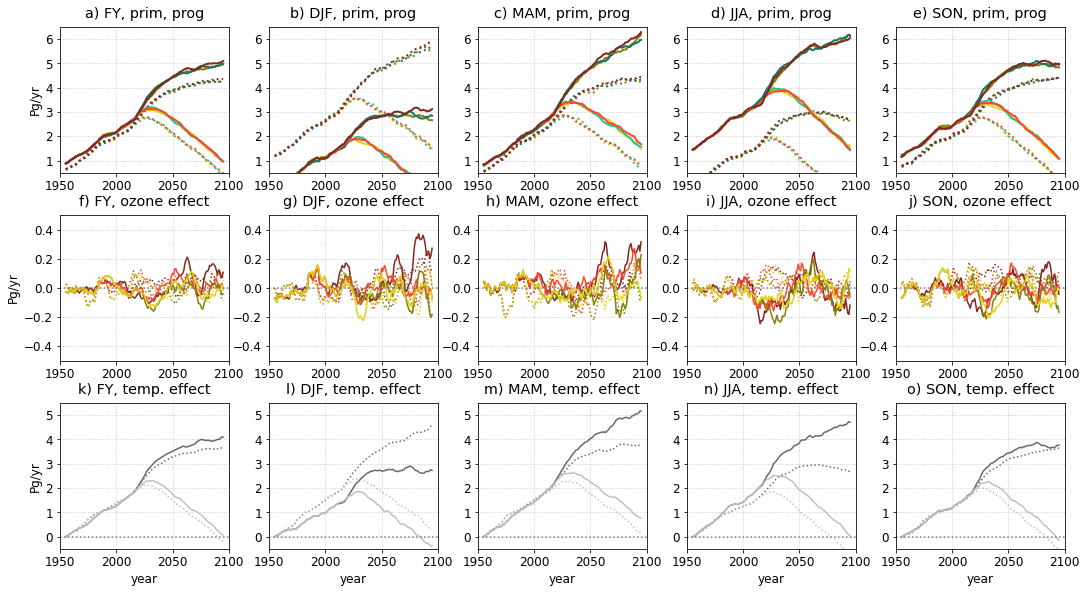

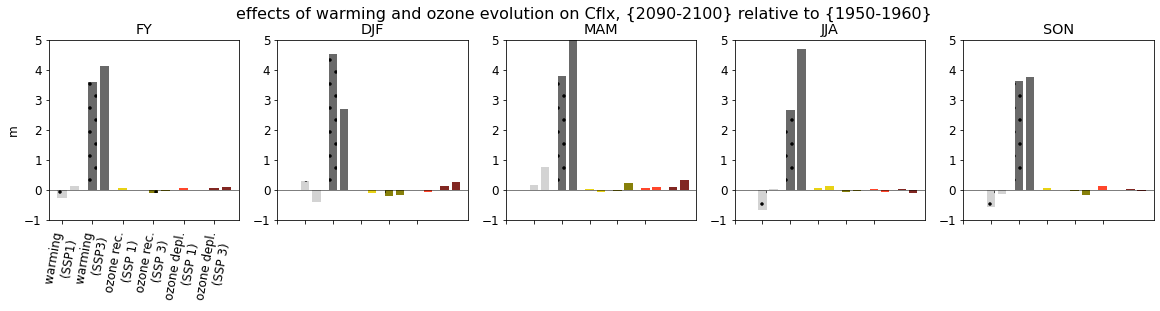

In [26]:
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

tlw = 1.5
tlw2 = 0.3 #linewidth
fact = 1.2
ypos = 1.02
fs2 = 10
var = 'Cflx'; vardesc = 'prim, prog'; ylab = 'Pg/yr'

fig, axs = plt.subplots(3,5, figsize=(15*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


# #####
wspdset = [Cflx_ukesm_1A, Cflx_ukesm_1B, Cflx_ukesm_2A, Cflx_ukesm_2B, Cflx_ukesm_3A, Cflx_ukesm_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

Cflx_ukesm_2A_50 = Cflx_ukesm_2A.isel(time_counter=slice(0,120))
Cflx_ukesm_2B_50 = Cflx_ukesm_2B.isel(time_counter=slice(0,120))

wspdset_o3 = [(Cflx_ukesm_3B-Cflx_ukesm_2B), (Cflx_ukesm_3A-Cflx_ukesm_2A), \
              (Cflx_ukesm_1B-Cflx_ukesm_2B), (Cflx_ukesm_1A-Cflx_ukesm_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']

#wspdset_t = [(wspd_2B-wspd_2B_50), (wspd_2A-wspd_2A_50)]
cols_t = ['dimgrey', 'silver']
scens_t = ['high temp.','low temp.']

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1)
    
#axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)

##### ozone effect
ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1)
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1)
    
#### temperature effect
ind = 10
tv = Cflx_ukesm_2B[var].groupby('time_counter.year').mean()-\
Cflx_ukesm_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = Cflx_ukesm_2B[var].sel(time_counter=(Cflx_ukesm_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2B_50[var].sel(time_counter=(Cflx_ukesm_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = Cflx_ukesm_2B[var].sel(time_counter=(Cflx_ukesm_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2B_50[var].sel(time_counter=(Cflx_ukesm_2B_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])
    
tv = Cflx_ukesm_2B[var].sel(time_counter=(Cflx_ukesm_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2B_50[var].sel(time_counter=(Cflx_ukesm_2B_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = Cflx_ukesm_2B[var].sel(time_counter=(Cflx_ukesm_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2B_50[var].sel(time_counter=(Cflx_ukesm_2B_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])    
    
tv = Cflx_ukesm_2A[var].groupby('time_counter.year').mean()-\
Cflx_ukesm_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = Cflx_ukesm_2A[var].sel(time_counter=(Cflx_ukesm_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2A_50[var].sel(time_counter=(Cflx_ukesm_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = Cflx_ukesm_2A[var].sel(time_counter=(Cflx_ukesm_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2A_50[var].sel(time_counter=(Cflx_ukesm_2A_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])
    
tv = Cflx_ukesm_2A[var].sel(time_counter=(Cflx_ukesm_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2A_50[var].sel(time_counter=(Cflx_ukesm_2A_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = Cflx_ukesm_2A[var].sel(time_counter=(Cflx_ukesm_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
Cflx_ukesm_2A_50[var].sel(time_counter=(Cflx_ukesm_2A_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])  
##low T

# #####
wspdset = [Cflx_tom_1A, Cflx_tom_1B, Cflx_tom_2A, Cflx_tom_2B, Cflx_tom_3A, Cflx_tom_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

Cflx_tom_2A_50 = Cflx_tom_2A.isel(time_counter=slice(0,120))
Cflx_tom_2B_50 = Cflx_tom_2B.isel(time_counter=slice(0,120))

wspdset_o3 = [(Cflx_tom_3B-Cflx_tom_2B), (Cflx_tom_3A-Cflx_tom_2A), \
              (Cflx_tom_1B-Cflx_tom_2B), (Cflx_tom_1A-Cflx_tom_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']

#wspdset_t = [(wspd_2B-wspd_2B_50), (wspd_2A-wspd_2A_50)]
cols_t = ['dimgrey', 'silver']
scens_t = ['high temp.','low temp.']

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1)
    
#axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)

##### ozone effect
ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1)
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1)
    
#### temperature effect
ind = 10
tv = Cflx_tom_2B[var].groupby('time_counter.year').mean()-\
Cflx_tom_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = Cflx_tom_2B[var].sel(time_counter=(Cflx_tom_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
Cflx_tom_2B_50[var].sel(time_counter=(Cflx_tom_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = Cflx_tom_2B[var].sel(time_counter=(Cflx_tom_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
Cflx_tom_2B_50[var].sel(time_counter=(Cflx_tom_2B_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])
    
tv = Cflx_tom_2B[var].sel(time_counter=(Cflx_tom_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
Cflx_tom_2B_50[var].sel(time_counter=(Cflx_tom_2B_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = Cflx_tom_2B[var].sel(time_counter=(Cflx_tom_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
Cflx_tom_2B_50[var].sel(time_counter=(Cflx_tom_2B_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])    
    
tv = Cflx_tom_2A[var].groupby('time_counter.year').mean()-\
Cflx_tom_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = Cflx_tom_2A[var].sel(time_counter=(Cflx_tom_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
Cflx_tom_2A_50[var].sel(time_counter=(Cflx_tom_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = Cflx_tom_2A[var].sel(time_counter=(Cflx_tom_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
Cflx_tom_2A_50[var].sel(time_counter=(Cflx_tom_2A_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])
    
tv = Cflx_tom_2A[var].sel(time_counter=(Cflx_tom_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
Cflx_tom_2A_50[var].sel(time_counter=(Cflx_tom_2A_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = Cflx_tom_2A[var].sel(time_counter=(Cflx_tom_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
Cflx_tom_2A_50[var].sel(time_counter=(Cflx_tom_2A_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])  
##low T

for i in range(0,15):
    axs[i].grid(color = 'grey', linestyle = ':', alpha = 0.5)
    
### effect
ymi = [0.5,0.5,0.5,0.5,0.5]
yma = [6.5,6.5,6.5,6.5,6.5,6.5]
tits0 = [f'a) FY, {vardesc}',f'b) DJF, {vardesc}',f'c) MAM, {vardesc}',\
        f'd) JJA, {vardesc}',f'e) SON, {vardesc}']
for i in range(0,5):
    axs[i].set_title(tits0[i], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[2].legend(loc = 'uCflxer left', ncol = 2, fontsize = fs2)
    #axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)
    #axs[3].legend(bbox_to_anchor = (1,1), ncol = 2, fontsize = 10)
    axs[i].set_ylim([ymi[i], yma[i]])
    axs[i].set_xlabel('')
    
tits = ['f) FY, ozone effect', 'g) DJF, ozone effect','h) MAM, ozone effect',\
        'i) JJA, ozone effect','j) SON, ozone effect']
ind = 5; ymi = -0.5; yma = 0.5
for i in range(0+ind,5+ind):
    axs[i].set_title(tits[i-ind], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[2+ind].legend(loc = 'uCflxer right', ncol = 2, fontsize = fs2-2)
    axs[i].set_ylim([ymi,yma])
    axs[i].axhline(y=0, color = 'grey', linestyle = ':')
    axs[i].set_xlabel('')
    
ind = 10; ymi = -0.5; yma = 5.5
tits1 = ['k) FY, temp. effect', 'l) DJF, temp. effect','m) MAM, temp. effect',\
        'n) JJA, temp. effect','o) SON, temp. effect']
for i in range(0+ind,5+ind):
    
    axs[i].set_title(tits1[i-ind], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[1+ind].legend(loc = 'uCflxer left', fontsize = fs2)
    axs[i].set_ylim([ymi,yma])
    axs[i].axhline(y=0, color = 'grey', linestyle = ':')
    
axs[0].set_ylabel(f'{ylab}')
axs[5].set_ylabel(f'{ylab}')
axs[10].set_ylabel(f'{ylab}')
    
    
    
tsp = 0.24
plt.subplots_adjust(wspace=tsp, hspace=tsp+0.05)    


fact = 1.1; tw = 0.3
fig, axs = plt.subplots(1,5, figsize=(18*fact, 3*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0; tseas = 'FY'
def plot_effects(ind,tseas):
    e_wl, e2 = get_effect_warming(Cflx_ukesm_2A, seas = tseas, var = 'Cflx')
    axs[ind].bar(1,e_wl, color = 'lightgrey',width=tw, hatch = '.')
    e_wh, e2 = get_effect_warming(Cflx_ukesm_2B, seas = tseas, var = 'Cflx')
    axs[ind].bar(2,e_wh, color = 'dimgrey',width=tw, hatch = '.')
    e, e2 = get_effect_ozone(Cflx_ukesm_1A, Cflx_ukesm_2A, seas = tseas, var = 'Cflx')
    axs[ind].bar(3,e2, color = scendict['1A']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(Cflx_ukesm_1B, Cflx_ukesm_2B, seas = tseas, var = 'Cflx')
    axs[ind].bar(4,e2, color = scendict['1B']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(Cflx_ukesm_3A, Cflx_ukesm_2A, seas = tseas, var = 'Cflx')
    axs[ind].bar(5,e2, color = scendict['3A']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(Cflx_ukesm_3B, Cflx_ukesm_2B, seas = tseas, var = 'Cflx')
    axs[ind].bar(6,e2, color = scendict['3B']['color'],width=tw, hatch = '.')

def plot_effects_tom(ind,tseas):
    e_wl, e2 = get_effect_warming(Cflx_tom_2A, seas = tseas, var = 'Cflx')
    axs[ind].bar(1.4,e_wl, color = 'lightgrey',width=tw)
    e_wh, e2 = get_effect_warming(Cflx_tom_2B, seas = tseas, var = 'Cflx')
    axs[ind].bar(2.4,e_wh, color = 'dimgrey',width=tw)
    e, e2 = get_effect_ozone(Cflx_tom_1A, Cflx_tom_2A, seas = tseas, var = 'Cflx')
    axs[ind].bar(3.4,e2, color = scendict['1A']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(Cflx_tom_1B, Cflx_tom_2B, seas = tseas, var = 'Cflx')
    axs[ind].bar(4.4,e2, color = scendict['1B']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(Cflx_tom_3A, Cflx_tom_2A, seas = tseas, var = 'Cflx')
    axs[ind].bar(5.4,e2, color = scendict['3A']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(Cflx_tom_3B, Cflx_tom_2B, seas = tseas, var = 'Cflx')
    axs[ind].bar(6.4,e2, color = scendict['3B']['color'],width=tw, hatch = '')

ind = 0; tseas = 'FY'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(1,7,1))
axs[ind].set_xticklabels(['warming \n(SSP1)', 'warming \n (SSP3)', 'ozone rec. \n (SSP 1)',\
                         'ozone rec. \n (SSP 3)','ozone depl. \n (SSP 1)','ozone depl. \n (SSP 3)'], rotation = 80)
ind = 1; tseas = 'DJF'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 2; tseas = 'MAM'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 3; tseas = 'JJA'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 4; tseas = 'SON'
plot_effects(ind,tseas)
plot_effects_tom(ind,tseas)
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)

tits = ['FY','DJF','MAM','JJA','SON',]
for ind in range(0,5):
    axs[ind].axhline(y=0, color = 'k', linewidth = 0.5)
    axs[ind].set_ylim(-1,5)
    axs[ind].set_title(tits[ind])
axs[0].set_ylabel('m')
plt.suptitle('effects of warming and ozone evolution on Cflx, {2090-2100} relative to {1950-1960}', y = 1.02, fontsize = 16)


In [27]:
fact = 1
fig, axs = plt.subplots(4,5, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

###
tlw = 1.5
tlw2 = 0.3 #linewidth
fact = 1.2
ypos = 1.02
fs2 = 10
var = 'max_OT'; vardesc = 'overturning'; ylab = 'Sv'
var1 = 'max_OT_yr'

# #####
wspdset = [ot_ukesm_1A, ot_ukesm_1B, ot_ukesm_2A, ot_ukesm_2B, ot_ukesm_3A, ot_ukesm_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

ot_ukesm_2A_50 = ot_ukesm_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
ot_ukesm_2B_50 = ot_ukesm_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(ot_ukesm_3B-ot_ukesm_2B), (ot_ukesm_3A-ot_ukesm_2A), \
              (ot_ukesm_1B-ot_ukesm_2B), (ot_ukesm_1A-ot_ukesm_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']

#wspdset_t = [(wspd_2B-wspd_2B_50), (wspd_2A-wspd_2A_50)]
cols_t = ['dimgrey', 'silver']
scens_t = ['high temp.','low temp.']

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var1].groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, linestyle = ':', alpha = 1)
    
#axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)

##### ozone effect
ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var1].groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1)
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth = tlw, linestyle = ':', alpha = 1)
    
#### temperature effect
ind = 10
tv = ot_ukesm_2B[var1].groupby('time_counter.year').mean()-\
ot_ukesm_2B_50[var1].mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = ot_ukesm_2B[var].sel(time_counter=(ot_ukesm_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
ot_ukesm_2B_50[var].sel(time_counter=(ot_ukesm_2B_50['time_counter.season'] == 'DJF')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = ot_ukesm_2B[var].sel(time_counter=(ot_ukesm_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
ot_ukesm_2B_50[var].sel(time_counter=(ot_ukesm_2B_50['time_counter.season'] == 'MAM')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])
    
tv = ot_ukesm_2B[var].sel(time_counter=(ot_ukesm_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
ot_ukesm_2B_50[var].sel(time_counter=(ot_ukesm_2B_50['time_counter.season'] == 'JJA')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])

tv = ot_ukesm_2B[var].sel(time_counter=(ot_ukesm_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
ot_ukesm_2B_50[var].sel(time_counter=(ot_ukesm_2B_50['time_counter.season'] == 'SON')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[0])    
    
tv = ot_ukesm_2A[var1].groupby('time_counter.year').mean()-\
ot_ukesm_2A_50[var1].mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = ot_ukesm_2A[var].sel(time_counter=(ot_ukesm_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
ot_ukesm_2A_50[var].sel(time_counter=(ot_ukesm_2A_50['time_counter.season'] == 'DJF')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = ot_ukesm_2A[var].sel(time_counter=(ot_ukesm_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
ot_ukesm_2A_50[var].sel(time_counter=(ot_ukesm_2A_50['time_counter.season'] == 'MAM')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])
    
tv = ot_ukesm_2A[var].sel(time_counter=(ot_ukesm_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
ot_ukesm_2A_50[var].sel(time_counter=(ot_ukesm_2A_50['time_counter.season'] == 'JJA')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])

tv = ot_ukesm_2A[var].sel(time_counter=(ot_ukesm_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
ot_ukesm_2A_50[var].sel(time_counter=(ot_ukesm_2A_50['time_counter.season'] == 'SON')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, linestyle = ':', alpha = 1, label = scens_t[1])  


# #####
wspdset = [ot_tom_1A, ot_tom_1B, ot_tom_2A, ot_tom_2B, ot_tom_3A, ot_tom_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

ot_tom_2A_50 = ot_tom_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
ot_tom_2B_50 = ot_tom_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(ot_tom_3B-ot_tom_2B), (ot_tom_3A-ot_tom_2A), \
              (ot_tom_1B-ot_tom_2B), (ot_tom_1A-ot_tom_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']

#wspdset_t = [(wspd_2B-wspd_2B_50), (wspd_2A-wspd_2A_50)]
cols_t = ['dimgrey', 'silver']
scens_t = ['high temp.','low temp.']

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var1].groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1, label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth = 2, linestyle = '-', alpha = 1)
    
#axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)

##### ozone effect
ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var1].groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1)
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth = tlw, linestyle = '-', alpha = 1)
    
#### temperature effect
ind = 10
tv = ot_tom_2B[var1].groupby('time_counter.year').mean()-\
ot_tom_2B_50[var1].mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = ot_tom_2B[var].sel(time_counter=(ot_tom_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
ot_tom_2B_50[var].sel(time_counter=(ot_tom_2B_50['time_counter.season'] == 'DJF')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = ot_tom_2B[var].sel(time_counter=(ot_tom_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
ot_tom_2B_50[var].sel(time_counter=(ot_tom_2B_50['time_counter.season'] == 'MAM')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])
    
tv = ot_tom_2B[var].sel(time_counter=(ot_tom_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
ot_tom_2B_50[var].sel(time_counter=(ot_tom_2B_50['time_counter.season'] == 'JJA')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])

tv = ot_tom_2B[var].sel(time_counter=(ot_tom_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
ot_tom_2B_50[var].sel(time_counter=(ot_tom_2B_50['time_counter.season'] == 'SON')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[0])    
    
tv = ot_tom_2A[var1].groupby('time_counter.year').mean()-\
ot_tom_2A_50[var1].mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = ot_tom_2A[var].sel(time_counter=(ot_tom_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
ot_tom_2A_50[var].sel(time_counter=(ot_tom_2A_50['time_counter.season'] == 'DJF')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = ot_tom_2A[var].sel(time_counter=(ot_tom_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
ot_tom_2A_50[var].sel(time_counter=(ot_tom_2A_50['time_counter.season'] == 'MAM')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])
    
tv = ot_tom_2A[var].sel(time_counter=(ot_tom_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
ot_tom_2A_50[var].sel(time_counter=(ot_tom_2A_50['time_counter.season'] == 'JJA')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])

tv = ot_tom_2A[var].sel(time_counter=(ot_tom_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
ot_tom_2A_50[var].sel(time_counter=(ot_tom_2A_50['time_counter.season'] == 'SON')).mean().values
tv = tv.chunk(10)
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, linestyle = '-', alpha = 1, label = scens_t[1])  


for i in range(0,15):
    axs[i].grid(color = 'grey', linestyle = ':', alpha = 0.5)
    
### effect
ymi = [15,15,15,15,15]
tits0 = [f'a) FY, {vardesc}',f'b) DJF, {vardesc}',f'c) MAM, {vardesc}',\
        f'd) JJA, {vardesc}',f'e) SON, {vardesc}']
for i in range(0,5):
    #axs[i].set_title(tits0[i], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[2].legend(loc = 'upper left', ncol = 2, fontsize = fs2)
    #axs[3].legend(loc = (0.06, 0.5), ncol = 2, fontsize = 10)
    #axs[3].legend(bbox_to_anchor = (1,1), ncol = 2, fontsize = 10)
    axs[i].set_ylim([ymi[i], ymi[i]+25])
    axs[i].set_xlabel('')
    
tits = ['f) FY, ozone effect', 'g) DJF, ozone effect','h) MAM, ozone effect',\
        'i) JJA, ozone effect','j) SON, ozone effect']
ind = 5; ymi = -5; yma = 7
for i in range(0+ind,5+ind):
    #axs[i].set_title(tits[i-ind], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[2+ind].legend(loc = 'upper right', ncol = 2, fontsize = fs2-2)
    axs[i].set_ylim([ymi,yma])
    axs[i].axhline(y=0, color = 'grey', linestyle = ':')
    axs[i].set_xlabel('')
    
ind = 10; ymi = -3; yma = 10
tits1 = ['k) FY, temp. effect', 'l) DJF, temp. effect','m) MAM, temp. effect',\
        'n) JJA, temp. effect','o) SON, temp. effect']
for i in range(0+ind,5+ind):
    
    #axs[i].set_title(tits1[i-ind], y = ypos)
    axs[i].set_xlim([1950,2100])
    #axs[1+ind].legend(loc = 'upper left', fontsize = fs2)
    axs[i].set_ylim([ymi,yma])
    axs[i].axhline(y=0, color = 'grey', linestyle = ':')
    
axs[0].set_ylabel(f'{ylab}')
axs[5].set_ylabel(f'{ylab}')
axs[10].set_ylabel(f'{ylab}')
    
    


####

def plot_effects(ind,tseas,tvar):
    e_wl, e2 = get_effect_warming(ot_ukesm_2A, seas= tseas, var = tvar )
    axs[ind].bar(1,e_wl, color = 'lightgrey',width=tw, hatch = '.')
    e_wh, e2 = get_effect_warming(ot_ukesm_2B, seas= tseas, var = tvar )
    axs[ind].bar(2,e_wh, color = 'dimgrey',width=tw, hatch = '.')
    e, e2 = get_effect_ozone(ot_ukesm_1A, ot_ukesm_2A, seas= tseas, var = tvar )
    axs[ind].bar(3,e2, color = scendict['1A']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(ot_ukesm_1B, ot_ukesm_2B, seas= tseas, var = tvar )
    axs[ind].bar(4,e2, color = scendict['1B']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(ot_ukesm_3A, ot_ukesm_2A, seas= tseas, var = tvar )
    axs[ind].bar(5,e2, color = scendict['3A']['color'],width=tw, hatch = '.')
    e, e2 = get_effect_ozone(ot_ukesm_3B, ot_ukesm_2B, seas= tseas, var = tvar )
    axs[ind].bar(6,e2, color = scendict['3B']['color'],width=tw, hatch = '.')

ind = 0; tseas = 'FY'; var = 'max_OT_yr'
def plot_effects_tom(ind,tseas,tvar):
    e_wl, e2 = get_effect_warming(ot_tom_2A, seas= tseas, var = tvar )
    axs[ind].bar(1.4,e_wl, color = 'lightgrey',width=tw, hatch = '')
    e_wh, e2 = get_effect_warming(ot_tom_2B, seas= tseas, var = tvar )
    axs[ind].bar(2.4,e_wh, color = 'dimgrey',width=tw, hatch = '')
    e, e2 = get_effect_ozone(ot_tom_1A, ot_tom_2A, seas= tseas, var = tvar )
    axs[ind].bar(3.4,e2, color = scendict['1A']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(ot_tom_1B, ot_tom_2B, seas= tseas, var = tvar )
    axs[ind].bar(4.4,e2, color = scendict['1B']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(ot_tom_3A, ot_tom_2A, seas= tseas, var = tvar )
    axs[ind].bar(5.4,e2, color = scendict['3A']['color'],width=tw, hatch = '')
    e, e2 = get_effect_ozone(ot_tom_3B, ot_tom_2B, seas= tseas, var = tvar )
    axs[ind].bar(6.4,e2, color = scendict['3B']['color'],width=tw, hatch = '')


ind = 15; tseas = 'FY'; var = 'max_OT_yr'
plot_effects(ind,tseas,'max_OT_yr')
plot_effects_tom(ind,tseas,'max_OT_yr')
axs[ind].set_xticks(np.arange(1,7,1))
axs[ind].set_xticklabels(['warming \n(SSP1)', 'warming \n (SSP3)', 'ozone rec. \n (SSP 1)',\
                         'ozone rec. \n (SSP 3)','ozone depl. \n (SSP 1)','ozone depl. \n (SSP 3)'], rotation = 80)
ind = 16; tseas = 'DJF'
plot_effects(ind,tseas,'max_OT')
plot_effects_tom(ind,tseas,'max_OT')
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 17; tseas = 'MAM'
plot_effects(ind,tseas,'max_OT')
plot_effects_tom(ind,tseas,'max_OT')
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 18; tseas = 'JJA'
plot_effects(ind,tseas,'max_OT')
plot_effects_tom(ind,tseas,'max_OT')
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)
ind = 19; tseas = 'SON'
plot_effects(ind,tseas,'max_OT')
plot_effects_tom(ind,tseas,'max_OT')
axs[ind].set_xticks(np.arange(0,6,1))
axs[ind].set_xticklabels(['','','','','','',], rotation = 60)

###
##################
### titles, etc
plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
t1 = 'maximum Southern Ocean meridional overturning circulation (MOC) , 1950-2100'
t2 = 'effect of ozone depletion on maximum Southern Ocean MOC, 1950-2100'
t3 = 'effect of warming on maximum Southern Ocean MOC, 1950-2100'
t4 = 'effect of warming and ozone evolution on maximum Southern Ocean MOC, $\overline{2090-2100} - \overline{1950-1960}$'
fs = 16

plt.figtext(0.5,0.92, t1, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.71, t2, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.5, t3, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.3, t4, ha="center", va="top", fontsize=fs, color="k")

# # #####
# for ind in range(15,20):
#     axs[ind].axhline(y=0, color = 'k', linewidth = 0.5)
#     axs[ind].set_ylim(-0.2,0.82)
# axs[0].set_ylabel('Sv')

# for i in range(0,20):
#     axs[i].tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
#     axs[i].grid(alpha = 0.5)
    
# for i in range(0,15):
#     axs[i].set_xlim([1950,2100])
#     axs[i].set_xlabel('')
    
# lab = ['a)','b)','c)','d)','e)',] 
# ymi = np.array([15,15,20,10,10])  
# hi = 30
# for i in range(0,5):
#     axs[i].set_ylim([ymi[i],ymi[i]+hi])
#     axs[i].text(1960,ymi[i]+0.85*hi,lab[i])
    
# lab = ['f)','g)','h)','i)','j)']  
# ymi = -5; hi=15
# for i in range(0,5):
#     axs[i+5].set_ylim([ymi,ymi+hi])
#     axs[i+5].text(1960,ymi+0.85*hi,lab[i])
    
# lab = ['k)','l)','m)','n)','o)']  
# ymi = -5; hi=15
# for i in range(0,5):
#     axs[i+10].set_ylim([ymi,ymi+hi])
#     axs[i+10].text(1960,ymi+0.85*hi,lab[i])
    
# lab = ['p)','q)','r)','s)','t)']  
# ymi = -2
# hi = 13
# for i in range(0,5):
#     axs[i+15].set_ylim([ymi,ymi+hi])
#     axs[i+15].set_xlim([0.7,6.7])
#     axs[i+15].text(1,ymi+0.85*hi,lab[i])
    
tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i])
    
# axs[7].legend(fontsize = 8)
# axs[12].legend()
#plt.tight_layout()
fig.savefig('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/figs/Fig-OTline.jpg')
   

<xarray.Dataset>
Dimensions:       (time_counter: 120)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1950-01-01 ... 1959-12-01
Data variables:
    Cflx          (time_counter) float64 ...
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/prim-prod.ipynb
    desc:     yearly meduA7 files, A7ving only variables of interest

In [28]:

# #####
wspdset = [Cflx_ukesm_1A, Cflx_ukesm_1B, Cflx_ukesm_2A, Cflx_ukesm_2B, Cflx_ukesm_3A, Cflx_ukesm_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

Cflx_ukesm_2A_50 = Cflx_ukesm_2A.sel(time_counter=slice('1950-01-01', '1960-01-01'))
Cflx_ukesm_2B_50 = Cflx_ukesm_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

In [29]:
Cflx_ukesm_2A.sel(time_counter=slice('1950-01-01', '1960-01-01'))

<xarray.Dataset>
Dimensions:       (time_counter: 121)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1950-01-01 ... 1960-01-01
Data variables:
    Cflx          (time_counter) float64 ...
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/prim-prod.ipynb
    desc:     yearly meduA7 files, A7ving only variables of interest

In [30]:
PP_ukesm_1A.time_counter

<xarray.DataArray 'time_counter' (time_counter: 1800)>
array(['1950-01-01T00:00:00.000000000', '1950-02-01T00:00:00.000000000',
       '1950-03-01T00:00:00.000000000', ..., '2099-10-01T00:00:00.000000000',
       '2099-11-01T00:00:00.000000000', '2099-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1950-01-01 ... 2099-12-01

In [31]:
Cflx_tom_2A

<xarray.Dataset>
Dimensions:       (time_counter: 1800)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1950-01-01 ... 2099-12-01
Data variables:
    Cflx          (time_counter) float64 ...
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/prim-prod.ipynb
    desc:     yearly meduA7 files, A7ving only variables of interest